# <p style="text-align: center;"> Advanced Machine Learning

## <p style="text-align: center;"> Final Project

### <p style="text-align: center;"> Construction of an InceptionV3 model to recognize the gender from images <p style="text-align: center;"> & <p style="text-align: center;"> Generate Artificial Human Faces with DCGAN Model

#### <p style="text-align: center;"> <u> Team </u>
#####   <p style="text-align: center;"> João Raimundo (57454), Rui Roque (57588)

### 0.1. Import Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from PIL import Image
import tensorflow as tf
import pathlib
import shutil
import cv2
import glob
from tqdm import tqdm
import time

from keras import Input
from sklearn.metrics import f1_score
from tensorflow import keras
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD 

from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

### 1. Objetive 1 - Construction of an InceptionV3 model to recognize the gender from images

### 1.1. Data Exploration


The CelebA dataset contains 200k photos of celebrities and their respective metadata with 40 attributes of each image:

In [ ]:
imgs_folder = 'Project_Data/archive/img_align_celeba/'
img_example = imgs_folder + "/000879.jpg"

**Load the attributes of every celebrity image**

In [ ]:
df_attributes = pd.read_csv('Project_Data/archive/list_attr_celeba.csv')
df_attributes.set_index('image_id', inplace=True)
df_attributes.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attributes.shape

(202599, 40)

**List of all attributes in the CelebA dataset**

In [ ]:
for i, j in enumerate(df_attributes.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


In [ ]:
df_attributes

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
image_id                                                                     
000001.jpg                 0                1           1                0   
000002.jpg                 0                0           0                1   
000003.jpg                 0                0           0                0   
000004.jpg                 0                0           1                0   
000005.jpg                 0                1           1                0   
...                      ...              ...         ...              ...   
202595.jpg                 0                0           1                0   
202596.jpg                 0                0           0                0   
202597.jpg                 0                0           0                0   
202598.jpg                 0                1           1                0   
202599.jpg                 0                1           1                0   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
image_id                                                             ...   
000001.jpg     0      0         0         0           0           0  ...   
000002.jpg     0      0         0         1           0           0  ...   
000003.jpg     0      0         1         0           0           0  ...   
000004.jpg     0      0         0         0           0           0  ...   
000005.jpg     0      0         1         0           0           0  ...   
...          ...    ...       ...       ...         ...         ...  ...   
202595.jpg     0      0         1         0           0           1  ...   
202596.jpg     0      1         1         0           0           1  ...   
202597.jpg     0      0         0         0           1           0  ...   
202598.jpg     0      0         1         0           1           0  ...   
202599.jpg     0      0         0         0           0           1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
image_id                                                                     
000001.jpg          0        1              1          0                 1   
000002.jpg          0        1              0          0                 0   
000003.jpg          0        0              0          1                 0   
000004.jpg          0        0              1          0                 1   
000005.jpg          0        0              0          0                 0   
...               ...      ...            ...        ...               ...   
202595.jpg          0        0              0          0                 0   
202596.jpg          0        1              1          0                 0   
202597.jpg          0        1              0          0                 0   
202598.jpg          0        1              0          1                 1   
202599.jpg          0        0              0          1                 0   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
image_id                                                                       
000001.jpg            0                 1                 0                0   
000002.jpg            0                 0                 0                0   
000003.jpg            0                 0                 0                0   
000004.jpg            0                 1                 1                0   
000005.jpg            0                 1                 0                0   
...                 ...               ...               ...              ...   
202595.jpg            0                 1                 0                0   
202596.jpg            0                 0                 0                0   
202597.jpg            0                 0                 0                0   
202598.jpg            0                 1                 0                0   
202599.jpg            0          

**Example images from CelebA dataset**

Smiling       1
Attractive    0
Black_Hair    1
Big_Nose      0
Big_Lips      0
Male          1
Young         0
Name: 000879.jpg, dtype: int64

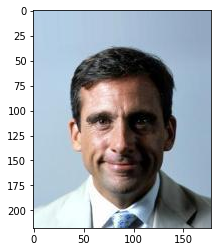

In [ ]:
img = load_img(img_example)
plt.grid(False)
plt.imshow(img)
df_attributes.loc[img_example.split("/")[-1]][['Smiling','Attractive','Black_Hair', 'Big_Nose', 'Big_Lips','Male','Young']]

In [ ]:
images = []
for image in tqdm(os.listdir(imgs_folder)[:25]):
    img = Image.open(imgs_folder + image)
    images.append(np.uint8(img))

100%|██████████| 25/25 [00:00<00:00, 1915.14it/s]


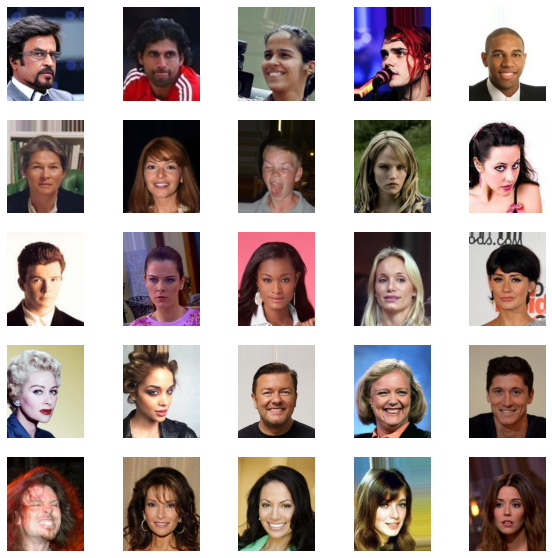

In [ ]:
#Display first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

**Distribution of the Attribute Gender**

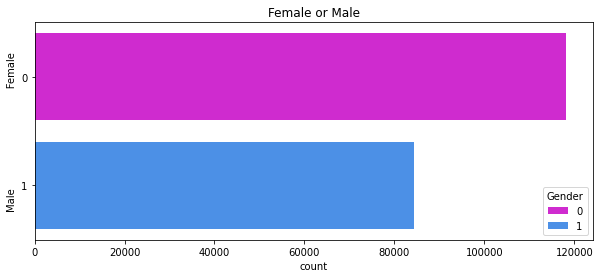

In [ ]:
plt.figure(1, figsize=(10, 4))
plt.title("Female or Male")
sns.countplot(y="Male", data=df_attributes, palette=['#EA10EA',"#338DFF"], hue="Male", dodge=False)  
plt.legend(title='Gender')
plt.ylabel("Male                                Female")
plt.show()


This plot give us some insight about the distribution of the gender attribute in the dataset.

There are more Female than Male gender, so we will need to balance the data.

### 1.2. Split Dataset into Training, Validation and Test

**Load partition list for the dataset**

In [ ]:
df_split = pd.read_csv("Project_Data/archive/list_eval_partition.csv")
df_split.head()

image_id  partition
0  000001.jpg          0
1  000002.jpg          0
2  000003.jpg          0
3  000004.jpg          0
4  000005.jpg          0

**Number of images for each split (0:Training; 1:Validation; 2:Test)**

In [ ]:
df_split["partition"].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

Since we only need the gender attribute, we will join the partition and the gender attribute in the same data frame:

In [ ]:
df_split.set_index("image_id", inplace=True)
df_split_gender = df_split.join(df_attributes["Male"], how="inner")
df_split_gender.head()

partition  Male
image_id                   
000001.jpg          0     0
000002.jpg          0     0
000003.jpg          0     1
000004.jpg          0     0
000005.jpg          0     0

**Number of Males and Females in the Train partition**

In [ ]:
print("Females in the Train partition: ", ((df_split_gender["Male"] == 0) & (df_split_gender["partition"] == 0)).sum())

print("Males in the Train partition: ", ((df_split_gender["Male"] == 1) & (df_split_gender["partition"] == 0)).sum())

Females in the Train partition:  94509
Males in the Train partition:  68261


**Number of Males and Females in the Validation partition**

In [ ]:
print("Females in the Validation partition: ", ((df_split_gender["Male"] == 0) & (df_split_gender["partition"] == 1)).sum())

print("Males in the Validation partition: ", ((df_split_gender["Male"] == 1) & (df_split_gender["partition"] == 1)).sum())

Females in the Validation partition:  11409
Males in the Validation partition:  8458


**Number of Males and Females in the Test partition**

In [ ]:
print("Females in the Test partition: ", ((df_split_gender["Male"] == 0) & (df_split_gender["partition"] == 2)).sum())

print("Males in the Test partition: ", ((df_split_gender["Male"] == 1) & (df_split_gender["partition"] == 2)).sum())

Females in the Test partition:  12247
Males in the Test partition:  7715


**Generate Train, Validation and Test partition** 

As we said before, the number of images need to be balanced in order to get a good performance for the model.

In the following steps we will solve this problem.

The number of samples for each partition was selected taking into account the total values obtained for each partition in the previous cells.

In [ ]:
# set parameters

TRAIN_SAMPLES = 10000
VAL_SAMPLES = 2500
TEST_SAMPLES = 2500
BATCH_SIZE = 16
EPOCHS = 20
HEIGHT = 218
WIDTH = 178

**Function that balances the Train, Validation and Test partitions**

In [ ]:
def balance_df(attribute):
    print("Attribute: ", attribute)

    df_train = df_split_gender[(df_split_gender["partition"] == 0) & (df_split_gender[attribute] == 0)].sample(int(TRAIN_SAMPLES))
    df_train = pd.concat([df_train, df_split_gender[(df_split_gender["partition"] == 0) & (df_split_gender[attribute] == 1)].sample(int(TRAIN_SAMPLES))])

    print("\nBalancing Train:\n", df_train[attribute].value_counts())

    df_val = df_split_gender[(df_split_gender["partition"] == 1) & (df_split_gender[attribute] == 0)].sample(int(VAL_SAMPLES))
    df_val = pd.concat([df_val, df_split_gender[(df_split_gender["partition"] == 1) & (df_split_gender[attribute] == 1)].sample(int(VAL_SAMPLES))])

    print("\nBalacing Validation:\n", df_val[attribute].value_counts())

    df_test = df_split_gender[(df_split_gender["partition"] == 2) & (df_split_gender[attribute] == 0)].sample(int(TEST_SAMPLES))
    df_test = pd.concat([df_test, df_split_gender[(df_split_gender["partition"] == 2) & (df_split_gender[attribute] == 1)].sample(int(TEST_SAMPLES))])

    print("\nBalacing Test:\n", df_test[attribute].value_counts())

    print("-------------")

    return df_train, df_val, df_test

**Function that creates folders for each partition and selected attributes**

In [ ]:
def create_folder(prefix):
    list_partitions = ["train", "validation", "test"]
    
    #delete path if exists
    for partition in list_partitions:
        if(os.path.exists("celeba-dataset/{}-{}".format(prefix, partition))):
            shutil.rmtree("celeba-dataset/{}-{}".format(prefix, partition))

    #create paths for training, validation and test images
    for partition in list_partitions:
        os.makedirs("celeba-dataset/{}-{}".format(prefix, partition))
        os.makedirs("celeba-dataset/{}-{}/0".format(prefix, partition))
        os.makedirs("celeba-dataset/{}-{}/1".format(prefix, partition))

**Function that copy images to each corresponding partition and attribute folder**

In [ ]:
def images_partition(prefix, attribute, images, type):

    #copy images
    for i, j in images.iterrows():
        if(j[attribute] == 0):
            shutil.copy("Project_Data/archive/img_align_celeba/" + i, "celeba-dataset/{}-{}/0/{}".format(prefix, type, i))
        if(j[attribute] == 1):
            shutil.copy("Project_Data/archive/img_align_celeba/" + i, "celeba-dataset/{}-{}/1/{}".format(prefix, type, i))

**Function that count the number of images in each partition and attribute folder**

In [ ]:
def count_images_partition(prefix):
    print("\nData for {} Model".format(prefix))

    list_partitions = ["train", "validation", "test"]

    for partition in list_partitions:
        print("{}:".format(partition))
        print(" {}:".format("Female"), len(os.listdir("celeba-dataset/{}-{}/0/".format(prefix, partition))))
        print(" {}:".format("Male"), len(os.listdir("celeba-dataset/{}-{}/1/".format(prefix, partition))))

**Function to process Test set**

In [ ]:
def preprocess_test(prefix):
    x_test = []
    y_test = []

    #0-Female  1-Male
    for i in [0,1]:
        #for j in a list of path names that match pathname
        for j in glob.glob("celeba-dataset/{}-test/{}/*.jpg".format(prefix, i)):
            image = cv2.imread(j.replace('\\','/'))
            #Confirms that an image is in RGB format and standardize values to be in the [0, 1] range
            image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (WIDTH, HEIGHT)).astype(np.float32) / 255.0
            #Update batch size
            image = np.expand_dims(image, axis =0)
            x_test.append(image)
            y_test.append(i)

    return x_test, y_test


**Split into partitions**

In [ ]:
create_folder("gender")

df_gender_train, df_gender_validation, df_gender_test = balance_df("Male")

images_partition("gender", "Male", df_gender_train, "train")
images_partition("gender", "Male", df_gender_validation, "validation")
images_partition("gender", "Male", df_gender_test, "test")

count_images_partition("gender")

Attribute:  Male

Balancing Train:
 0    10000
1    10000
Name: Male, dtype: int64

Balacing Validation:
 0    2500
1    2500
Name: Male, dtype: int64

Balacing Test:
 0    2500
1    2500
Name: Male, dtype: int64
-------------

Data for gender Model
train:
 Female: 10000
 Male: 10000
validation:
 Female: 2500
 Male: 2500
test:
 Female: 2500
 Male: 2500


### 1.3. Augmentation and Standardization of data

**Defining the parameters**

In [ ]:
augm_stand_data = ImageDataGenerator(
  preprocessing_function=preprocess_input, # standardize data [-1,1]
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

**Example of an image augmented and scaled**

100%|██████████| 10/10 [00:00<00:00, 1628.48it/s]


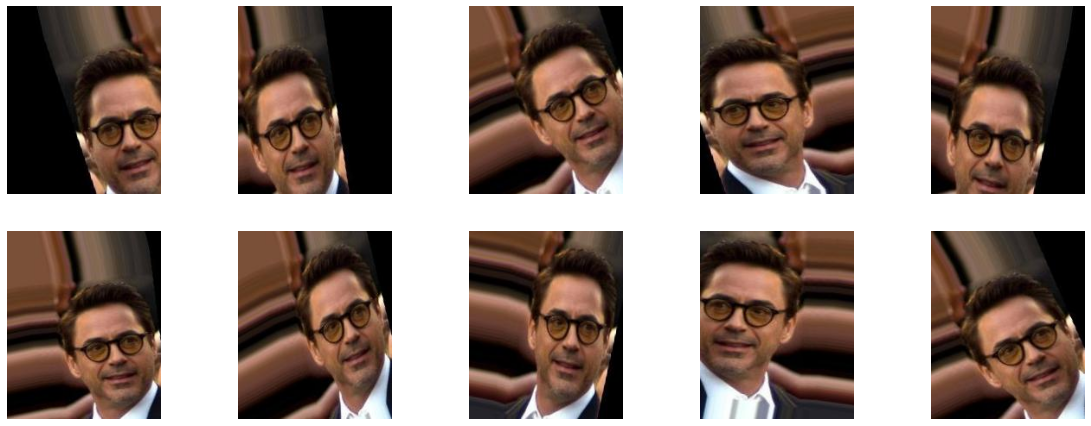

In [ ]:
example_img = load_img("Project_Data/archive/img_align_celeba/195516.jpg")

x = img_to_array(example_img)
x = x.reshape((1,) + x.shape)

# Delete path if exists
if os.path.exists('celeba-dataset/data_augmentation_sample'):
   shutil.rmtree('celeba-dataset/data_augmentation_sample')

# Create paths for data augmentation sample
os.makedirs('celeba-dataset/data_augmentation_sample')

#create just 10 pics as example
i = 0
for batch in augm_stand_data.flow(x, batch_size=1,
              save_to_dir='celeba-dataset/data_augmentation_sample', save_prefix='data_aug', save_format='jpg'):
    if i == 9:
        break
    i += 1


images = []
for image in tqdm(os.listdir("celeba-dataset/data_augmentation_sample/")):
    img = Image.open("celeba-dataset/data_augmentation_sample/" + image)
    images.append(np.uint8(img))

plt.figure(1, figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

**Augmenting and Scaling Train and Validation sets**

In [ ]:
train_augm_stand = augm_stand_data.flow_from_directory(
																	'celeba-dataset/{}-train'.format("gender"),
																	target_size=(HEIGHT, WIDTH),
																	batch_size=BATCH_SIZE)


val_augm_stand = augm_stand_data.flow_from_directory(
																			'celeba-dataset/{}-validation'.format("gender"),
																			target_size=(HEIGHT, WIDTH),
																			batch_size=BATCH_SIZE)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### 1.4. Build the Model - Gender Recognition

**Defining the Inception Model**

This model was pre-trained (weights) with Imagenet dataset. We will perform a transfer learning. Thus, we dont included the top layers of the model, which are responsible to identify the labels.

In [ ]:
inception_model = InceptionV3(  weights="imagenet",
                                include_top=False,
                                input_shape=(HEIGHT, WIDTH, 3))

print("Number of layers: ", len(inception_model.layers))

inception_model.summary()

Number of layers:  311
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 108, 88, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 108, 88, 32)  96         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                

To adapt the model to our dataset we add some custom layers

In [ ]:
# Adding custom Layers
x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation = "relu")(x)
predicts = Dense(2, activation = "softmax")(x)



The custom classifier is fed into to the main model by feeding in the prediction argument. The weights of the main body needs to be frozen to prevent their update during back propagation period. By looping through the layer of the model and freezing the weights we can accomplish the update prevention before training the custom classifier.

To compile the model we choose as optimizer the Stochastic Gradient Descent (SGD) with a very small learning rate of 0.0001 to allow the newly designed custom classifier to learn higher and lower level features from the earlier frozen convolutional layers; For the metric we select the 'Accuracy' and as loss function we used the Categorical Crossentropy.

In [ ]:
# creating the final model 
model = Model(inputs=inception_model.input, outputs=predicts)

for layer in model.layers[:52]:
    layer.trainable = False

# compile the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])


/home/fc.ul.pt/fc57588/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 1.5. Training the Model

**Checkpoint path to save the best results**

In [ ]:
!mkdir -p 'Project_Data/archive/saved_models'

In [ ]:
checkpointer = ModelCheckpoint(filepath='Project_Data/archive/saved_models/gender_best_weights2.hdf5', 
                               verbose=1, save_best_only=True)


In [ ]:
history = model.fit(train_augm_stand,
          validation_data = val_augm_stand,
          steps_per_epoch= (TRAIN_SAMPLES*2)/BATCH_SIZE,
          epochs = EPOCHS,
          callbacks=[checkpointer]
          )


Epoch 1/20


2022-05-27 14:25:25.163475: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


1250/1250 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8033
Epoch 1: val_loss improved from inf to 0.22244, saving model to Project_Data/archive/saved_models/gender_best_weights2.hdf5
1250/1250 [==============================] - 234s 179ms/step - loss: 0.4151 - accuracy: 0.8033 - val_loss: 0.2224 - val_accuracy: 0.9104
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.9008
Epoch 2: val_loss improved from 0.22244 to 0.16028, saving model to Project_Data/archive/saved_models/gender_best_weights2.hdf5
1250/1250 [==============================] - 221s 176ms/step - loss: 0.2418 - accuracy: 0.9008 - val_loss: 0.1603 - val_accuracy: 0.9368
Epoch 3/20
1250/1250 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9193
Epoch 3: val_loss improved from 0.16028 to 0.13654, saving model to Project_Data/archive/saved_models/gender_best_weights2.hdf5
1250/1250 [==============================] - 220s 176ms/step - 

### 1.6. Model Evaluation

Plot accuracy and loss values for training and validations set over the epoches

<Figure size 1296x576 with 0 Axes>

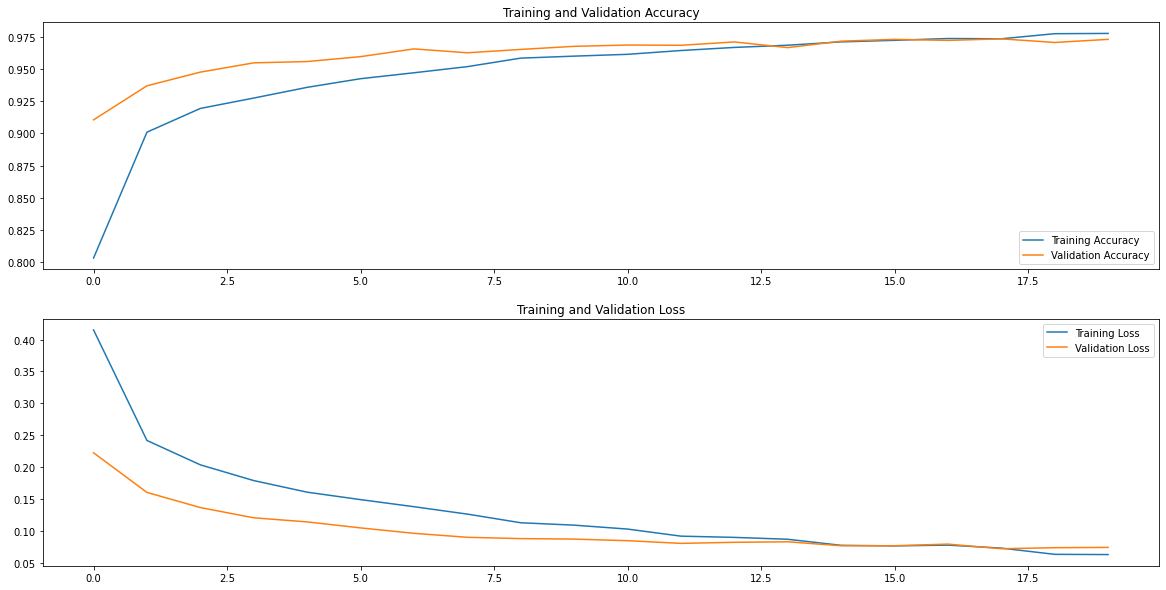

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(18, 8))
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax1.set_title('Training and Validation Accuracy')
ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')
plt.show()

### 1.7. Test Model

Testing the model with Test set from CelebaA dataset

In [ ]:
model.load_weights('Project_Data/archive/saved_models/gender_best_weights2.hdf5')

In [ ]:
x_test, y_test = preprocess_test('gender')

In [ ]:
# generate prediction
model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Gender Model')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

1/1 [==============================] - 0s 52ms/step
Gender Model
Test accuracy: 96.9600%
f1_score: 0.9697211155378487


In [ ]:
model.save('Project_Data/archive/saved_models/gender_model.h5')

**Testing the Model with images that are not from the dataset**

In [ ]:
def make_prediction(filePath):

  pic = load_img(filePath)
  image = cv2.imread(filePath)
  
  # Confirms that an image is in RGB format and standardize values to be in the [0, 1] range
  image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
  image = np.expand_dims(image, axis =0)

  gender_result = model.predict(image)
  gender = np.argmax(gender_result)

  
  plt.imshow(pic)
  plt.axis("off")

  if(gender == 0):
    print("\nIt's a Female!")
  else:
    print("\nIt's a Male!")

  
  print("\nGender Accuracy: {0:.2f}% \n\n".format(round(max(gender_result[0])*100, 2))) 
    

1/1 [==============================] - 0s 53ms/step

It's a Male!

Gender Accuracy: 99.86% 




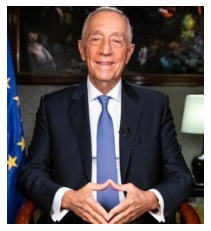

In [ ]:
make_prediction("Project_Data/archive/images_no_celeba/marcelo.jpg")

1/1 [==============================] - 0s 50ms/step

It's a Female!

Gender Accuracy: 59.59% 




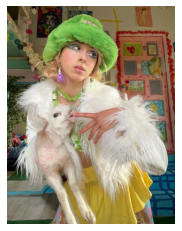

In [ ]:
make_prediction("Project_Data/archive/images_no_celeba/marie.jpg")

1/1 [==============================] - 0s 55ms/step

It's a Male!

Gender Accuracy: 99.62% 




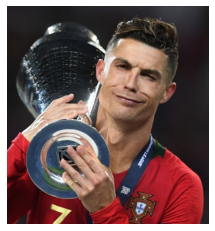

In [ ]:
make_prediction("Project_Data/archive/images_no_celeba/cristiano.jpg")

1/1 [==============================] - 0s 49ms/step

It's a Female!

Gender Accuracy: 82.69% 




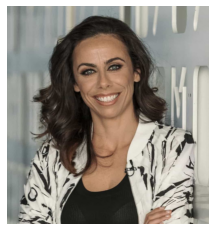

In [ ]:
make_prediction("Project_Data/archive/images_no_celeba/filomena.jpg")

1/1 [==============================] - 0s 58ms/step

It's a Male!

Gender Accuracy: 52.47% 




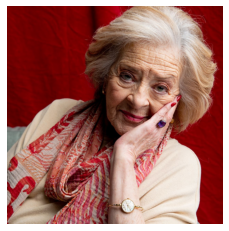

In [ ]:
make_prediction("Project_Data/archive/images_no_celeba/simone.jpg")

1/1 [==============================] - 0s 56ms/step

It's a Male!

Gender Accuracy: 95.87% 




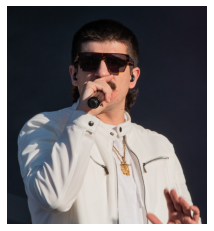

In [ ]:
make_prediction("Project_Data/archive/images_no_celeba/Profjam.jpg")

We tried that the photos tested were not easy to predict, they contained additional elements, different poses and backgrounds. The obtained results shown a good model performance to recognize male photographs. For female photographs, the model demonstrates that it cannot correctly predict older people (several photos were tested with the same result), for more detailed photographs the model was still able to effectively predict their gender (we speak of the photo with 59.59% accuracy).

### 2. Objetive 2 - Generate Artificial Human Faces with DCGAN Model

In this objetive we ill preprocess the images from CelebA dataset, to create a DCGAN Model in order to generate artificial human faces.

### 2.1. Preprocessing Data

In [ ]:
# set parameters
BATCH_SIZE = 128
NOISE_SHAPE = 100

**Import images from directory**

Creating an array with the image stored

In [ ]:
path_celeb = []
imgs_path = 'Project_Data/archive/img_align_celeba/'
for path in os.listdir(imgs_path):
    if '.jpg' in path:
         path_celeb.append(os.path.join(imgs_path, path))

**Selected Ramdomly 50000 images from the CelebA dataset**

In [ ]:
random.shuffle(path_celeb)
selected_imgs = path_celeb[0:50000]
print(len(selected_imgs))

50000


**Crop and Resize the images**

We cropped the images in order to the faces fit withe size of the image. Addicionally, the images were resize to 64x64 pixels.

In [ ]:
crop_sizes = (20, 35, 160, 185) # left, top, right,  bottom

images = [np.array((Image.open(path).crop(crop_sizes)).resize((64,64))) for path in selected_imgs]

len(images)

t = np.array(images)
t.shape

(50000, 64, 64, 3)

**Display Cropped and resize images**

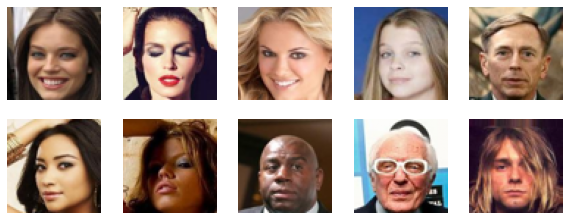

In [ ]:
plt.figure(1, figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i].reshape(64,64,3))
    plt.axis('off')
plt.show()

**Scaling the images**

The images were scale into -1 and 1, since we will use the hyperbolic tangent (“tanh”) as activation function of the model.

In [ ]:
train = (t - 127.5) / 127.5  # scale the images to [-1, 1]

**Create batch dataset**

We combined consecutive images from the array in batches of 128, creating a batch dataset.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train).batch(BATCH_SIZE)

### 2.2. Creating the Model

The feed-forward neural network of the DCGAN Model is composed by two neural network components:
* A generator that generate the artificial faces
 * A discriminator that receives the image from the generator and classify the image as fake or real.

The two components compete with each other (adversarial). The idea is the generator be capable to generate artificial faces that are classified in the discriminator as real human images.

**Generator**

The generator was defined starting with a dense layer with 512 filters that receives the noise as input shape and upscales the images.  Further, we use 3 conv2dtranspose (256, 128, 64) that will generate the images from the noise. In each of this layer we implement batch normalization and LeakyReLu activation layer - in order to help the inicialization of the layer. The last layer is a conv2dtranposed that used hyperbolic tangent as activation function.
The ideia is at the final the inputed image have as shape 64x64x3.

In [ ]:
generator = Sequential([
    layers.Dense(8*8*512, input_shape=[NOISE_SHAPE]),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape([8, 8, 512]),

    layers.Conv2DTranspose(256, kernel_size = 4, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    
    layers.Conv2DTranspose(128, kernel_size = 4, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(64, kernel_size = 4, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    layers.Conv2DTranspose(3, kernel_size=4, padding="same", activation="tanh")
])

In [ ]:
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32768)             3309568   
                                                                 
 batch_normalization_16 (Bat  (None, 32768)            131072    
 chNormalization)                                                
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 16, 16, 256)      2097408   
 Transpose)                                                      
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 256)     

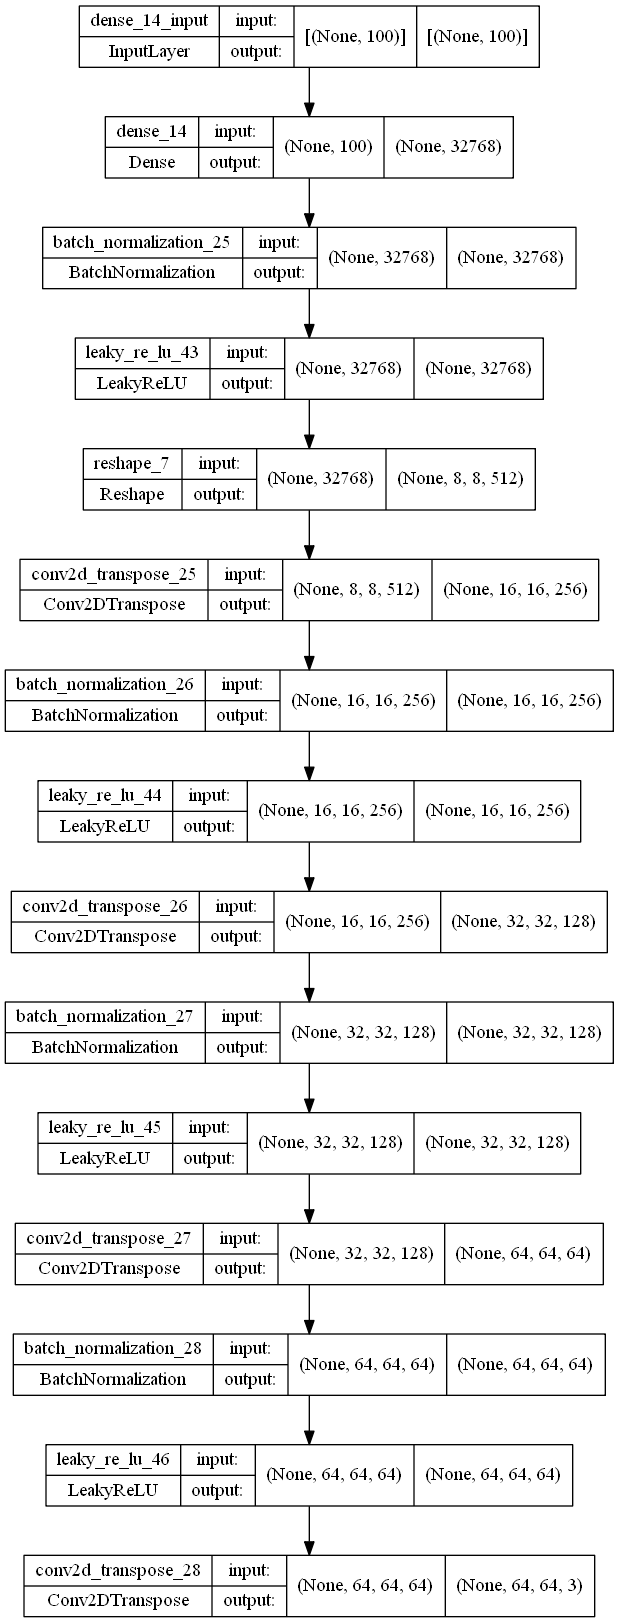

In [ ]:
Image(model_to_dot(generator, show_shapes=True).create_png())

**Discriminator**

The descriminator receives the output of the generator neural network. Thus, in first layer, which is a conv2d with 128 filters we seted the image input shape as 64x64x3. Addicionally, we define 2 more conv2d layers with 256 and 512 filters respectively. In each difined conv2d layer we set a LeakyReLu activation layer an a dropout layer of 0.3. Finally, as the last layers the difined a flatten and dense layer.

In [ ]:
discriminator = Sequential([
    layers.Conv2D(128, kernel_size = 4, strides=2, padding='same', input_shape = [64,64,3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(256, kernel_size = 4, strides=2, padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(512, kernel_size = 4, strides=2, padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1)

])

In [ ]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 128)       6272      
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_12 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 256)       524544    
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 dropout_13 (Dropout)        (None, 16, 16, 256)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 512)       

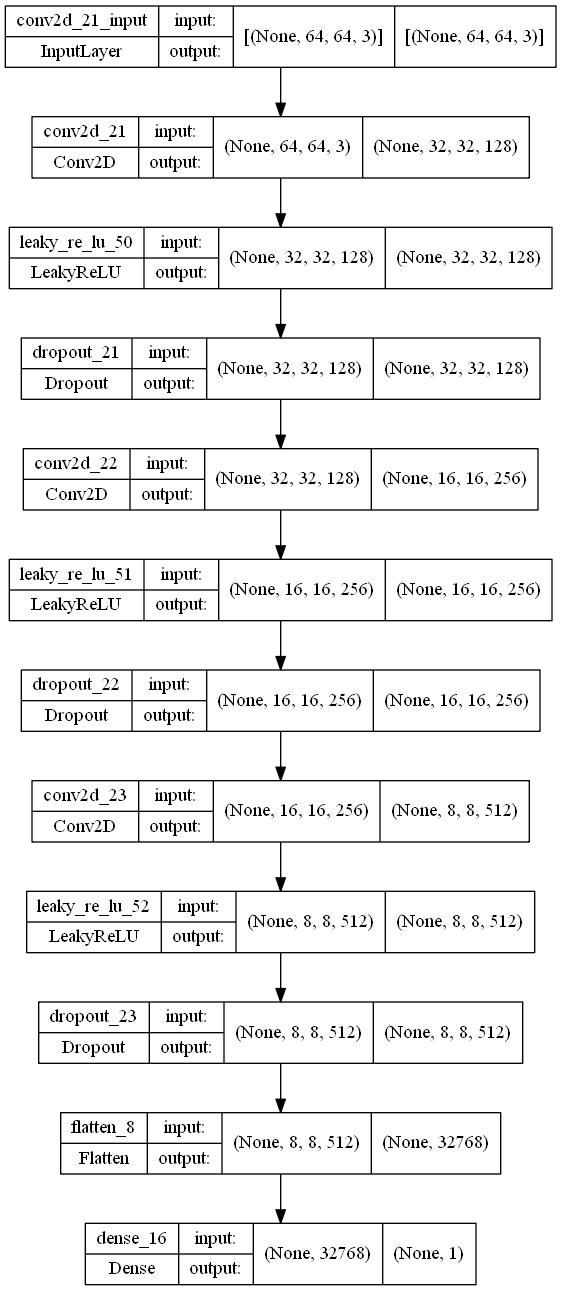

In [ ]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

**Create a noise image with the untrained generator to start the model**

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

**Classify the noise image with the discriminator**

Values ​​close to negative or negative are classified as fake. Positive values are classified was real images.

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00053876]], shape=(1, 1), dtype=float32)


**Define loss functions and optimizers for both models**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Define a Discriminator Loss Function**

Measures how well the discriminator is able to recognize real images from artifical images by comparing the discriminator's predictions on real images with a matrix of 1s and the predictions of the artificial images with a matrix of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**Define a Generator Loss Function**

Measures how well the generator was able to fool the discriminator. If generator performed well, the discriminator will classify the artificial images as real (1).

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**Define the optimizers**

Since the two neural network will be trained individually, we defined the optimizer for each one. It is the same - Adam.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 2.3. Training the Model

**Define a Training Loop Function**

The loop starts a random seed as input, that will generate a noise image. The discriminator will classify generated images and images from the CelebA dataset. The loss is calculated and the gradients are used to update the generator and discriminator for the next cicle.

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_SHAPE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

**Define the Training Function**

In [ ]:
def train(dataset, epochs):
  for epoch in tqdm(range(epochs)):
    print(f"\n--> Currently on Epoch {epoch+1}")
    start = time.time()

    for image_batch in dataset:   
      train_step(image_batch)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      generator.trainable = False
      predicts = generator.predict(np.random.normal(loc=0, scale=1, size=(10,100)))
      fig = plt.figure(figsize=(5, 5))
      for k in range(predicts.shape[0]):
          plt.subplot(5, 5, k+1)
          plt.imshow(((predicts[k].reshape(64,64,3) + 127.5) * 127.5).astype(np.uint8)) #How was before: predicts[k].reshape(64,64,3)
          plt.axis("off")

      plt.show()
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

**Perform the model training with 200 epochs**

  0%|          | 0/200 [00:00<?, ?it/s]


--> Currently on Epoch 1


  0%|          | 1/200 [02:41<8:54:51, 161.26s/it]

Time for epoch 1 is 161.26384663581848 sec

--> Currently on Epoch 2


  1%|          | 2/200 [05:13<8:34:59, 156.06s/it]

Time for epoch 2 is 152.40613174438477 sec

--> Currently on Epoch 3


  2%|▏         | 3/200 [07:45<8:26:40, 154.32s/it]

Time for epoch 3 is 152.241868019104 sec

--> Currently on Epoch 4


  2%|▏         | 4/200 [10:18<8:22:14, 153.75s/it]

Time for epoch 4 is 152.8742480278015 sec

--> Currently on Epoch 5
1/1 [==============================] - 0s 354ms/step


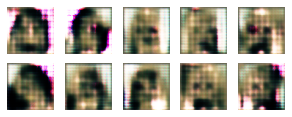

  2%|▎         | 5/200 [12:53<8:20:47, 154.09s/it]

Time for epoch 5 is 154.68461537361145 sec

--> Currently on Epoch 6


  3%|▎         | 6/200 [15:27<8:17:44, 153.94s/it]

Time for epoch 6 is 153.6552767753601 sec

--> Currently on Epoch 7


  4%|▎         | 7/200 [18:01<8:15:23, 154.01s/it]

Time for epoch 7 is 154.130056142807 sec

--> Currently on Epoch 8


  4%|▍         | 8/200 [20:35<8:13:06, 154.09s/it]

Time for epoch 8 is 154.27956795692444 sec

--> Currently on Epoch 9


  4%|▍         | 9/200 [23:09<8:10:39, 154.13s/it]

Time for epoch 9 is 154.21377730369568 sec

--> Currently on Epoch 10
1/1 [==============================] - 0s 30ms/step


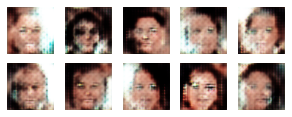

  5%|▌         | 10/200 [25:45<8:09:22, 154.54s/it]

Time for epoch 10 is 155.4436707496643 sec

--> Currently on Epoch 11


  6%|▌         | 11/200 [28:19<8:06:14, 154.36s/it]

Time for epoch 11 is 153.96402263641357 sec

--> Currently on Epoch 12


  6%|▌         | 12/200 [30:53<8:03:15, 154.23s/it]

Time for epoch 12 is 153.91612672805786 sec

--> Currently on Epoch 13


  6%|▋         | 13/200 [33:26<8:00:19, 154.12s/it]

Time for epoch 13 is 153.85319304466248 sec

--> Currently on Epoch 14


  7%|▋         | 14/200 [36:00<7:57:36, 154.07s/it]

Time for epoch 14 is 153.9472918510437 sec

--> Currently on Epoch 15
1/1 [==============================] - 0s 46ms/step


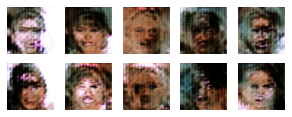

  8%|▊         | 15/200 [38:35<7:55:50, 154.33s/it]

Time for epoch 15 is 154.92606854438782 sec

--> Currently on Epoch 16


  8%|▊         | 16/200 [41:09<7:52:38, 154.12s/it]

Time for epoch 16 is 153.65134501457214 sec

--> Currently on Epoch 17


  8%|▊         | 17/200 [43:43<7:49:45, 154.02s/it]

Time for epoch 17 is 153.76475977897644 sec

--> Currently on Epoch 18


  9%|▉         | 18/200 [46:15<7:45:32, 153.47s/it]

Time for epoch 18 is 152.2041072845459 sec

--> Currently on Epoch 19


 10%|▉         | 19/200 [48:48<7:42:23, 153.28s/it]

Time for epoch 19 is 152.8182213306427 sec

--> Currently on Epoch 20
1/1 [==============================] - 0s 42ms/step


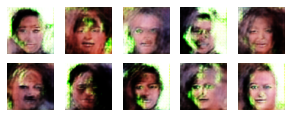

 10%|█         | 20/200 [51:22<7:40:35, 153.53s/it]

Time for epoch 20 is 154.11044764518738 sec

--> Currently on Epoch 21


 10%|█         | 21/200 [53:56<7:38:04, 153.55s/it]

Time for epoch 21 is 153.58407258987427 sec

--> Currently on Epoch 22


 11%|█         | 22/200 [56:30<7:35:58, 153.70s/it]

Time for epoch 22 is 154.04148626327515 sec

--> Currently on Epoch 23


 12%|█▏        | 23/200 [59:04<7:33:46, 153.82s/it]

Time for epoch 23 is 154.11303114891052 sec

--> Currently on Epoch 24


 12%|█▏        | 24/200 [1:01:37<7:31:04, 153.77s/it]

Time for epoch 24 is 153.65055084228516 sec

--> Currently on Epoch 25
1/1 [==============================] - 0s 42ms/step


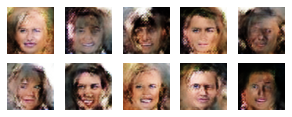

 12%|█▎        | 25/200 [1:04:11<7:28:15, 153.69s/it]

Time for epoch 25 is 153.4829728603363 sec

--> Currently on Epoch 26


 13%|█▎        | 26/200 [1:06:43<7:24:33, 153.30s/it]

Time for epoch 26 is 152.38405799865723 sec

--> Currently on Epoch 27


 14%|█▎        | 27/200 [1:09:17<7:22:09, 153.35s/it]

Time for epoch 27 is 153.45810222625732 sec

--> Currently on Epoch 28


 14%|█▍        | 28/200 [1:11:50<7:19:43, 153.39s/it]

Time for epoch 28 is 153.48245859146118 sec

--> Currently on Epoch 29


 14%|█▍        | 29/200 [1:14:23<7:16:35, 153.19s/it]

Time for epoch 29 is 152.7185423374176 sec

--> Currently on Epoch 30
1/1 [==============================] - 0s 41ms/step


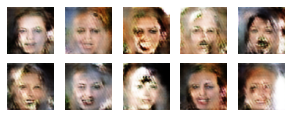

 15%|█▌        | 30/200 [1:16:55<7:13:30, 153.00s/it]

Time for epoch 30 is 152.56394028663635 sec

--> Currently on Epoch 31


 16%|█▌        | 31/200 [1:19:28<7:10:28, 152.83s/it]

Time for epoch 31 is 152.41977643966675 sec

--> Currently on Epoch 32


 16%|█▌        | 32/200 [1:22:01<7:08:22, 152.99s/it]

Time for epoch 32 is 153.3601953983307 sec

--> Currently on Epoch 33


 16%|█▋        | 33/200 [1:24:35<7:06:43, 153.31s/it]

Time for epoch 33 is 154.06731390953064 sec

--> Currently on Epoch 34


 17%|█▋        | 34/200 [1:27:10<7:04:58, 153.61s/it]

Time for epoch 34 is 154.28335571289062 sec

--> Currently on Epoch 35
1/1 [==============================] - 0s 42ms/step


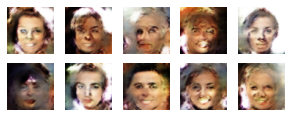

 18%|█▊        | 35/200 [1:29:44<7:03:26, 153.98s/it]

Time for epoch 35 is 154.84564328193665 sec

--> Currently on Epoch 36


 18%|█▊        | 36/200 [1:32:18<7:00:39, 153.90s/it]

Time for epoch 36 is 153.70033526420593 sec

--> Currently on Epoch 37


 18%|█▊        | 37/200 [1:34:51<6:57:28, 153.67s/it]

Time for epoch 37 is 153.1459891796112 sec

--> Currently on Epoch 38


 19%|█▉        | 38/200 [1:37:25<6:54:57, 153.69s/it]

Time for epoch 38 is 153.72199535369873 sec

--> Currently on Epoch 39


 20%|█▉        | 39/200 [1:39:59<6:52:20, 153.67s/it]

Time for epoch 39 is 153.60729932785034 sec

--> Currently on Epoch 40
1/1 [==============================] - 0s 39ms/step


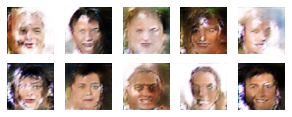

 20%|██        | 40/200 [1:42:33<6:50:10, 153.82s/it]

Time for epoch 40 is 154.1655671596527 sec

--> Currently on Epoch 41


 20%|██        | 41/200 [1:45:06<6:47:10, 153.65s/it]

Time for epoch 41 is 153.26534008979797 sec

--> Currently on Epoch 42


 21%|██        | 42/200 [1:47:40<6:44:39, 153.67s/it]

Time for epoch 42 is 153.69362950325012 sec

--> Currently on Epoch 43


 22%|██▏       | 43/200 [1:50:13<6:41:24, 153.40s/it]

Time for epoch 43 is 152.78339648246765 sec

--> Currently on Epoch 44


 22%|██▏       | 44/200 [1:52:45<6:37:57, 153.06s/it]

Time for epoch 44 is 152.26439476013184 sec

--> Currently on Epoch 45
1/1 [==============================] - 0s 43ms/step


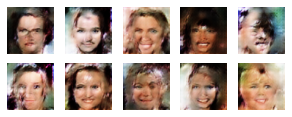

 22%|██▎       | 45/200 [1:55:18<6:35:17, 153.01s/it]

Time for epoch 45 is 152.89351177215576 sec

--> Currently on Epoch 46


 23%|██▎       | 46/200 [1:57:51<6:32:34, 152.95s/it]

Time for epoch 46 is 152.79577350616455 sec

--> Currently on Epoch 47


 24%|██▎       | 47/200 [2:00:24<6:30:43, 153.23s/it]

Time for epoch 47 is 153.86758136749268 sec

--> Currently on Epoch 48


 24%|██▍       | 48/200 [2:02:59<6:28:50, 153.49s/it]

Time for epoch 48 is 154.09263730049133 sec

--> Currently on Epoch 49


 24%|██▍       | 49/200 [2:05:32<6:26:28, 153.57s/it]

Time for epoch 49 is 153.74192190170288 sec

--> Currently on Epoch 50
1/1 [==============================] - 0s 45ms/step


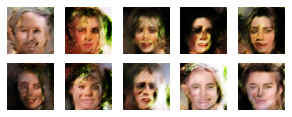

 25%|██▌       | 50/200 [2:08:55<7:00:27, 168.18s/it]

Time for epoch 50 is 202.28146982192993 sec

--> Currently on Epoch 51


 26%|██▌       | 51/200 [2:10:57<6:23:36, 154.48s/it]

Time for epoch 51 is 122.49079871177673 sec

--> Currently on Epoch 52


 26%|██▌       | 52/200 [2:13:01<5:58:34, 145.37s/it]

Time for epoch 52 is 124.11762070655823 sec

--> Currently on Epoch 53


 26%|██▋       | 53/200 [2:15:05<5:40:05, 138.81s/it]

Time for epoch 53 is 123.5068609714508 sec

--> Currently on Epoch 54


 27%|██▋       | 54/200 [2:17:08<5:26:31, 134.19s/it]

Time for epoch 54 is 123.38970351219177 sec

--> Currently on Epoch 55
1/1 [==============================] - 0s 48ms/step


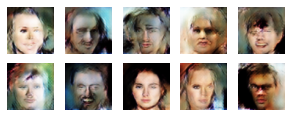

 28%|██▊       | 55/200 [2:19:12<5:17:02, 131.19s/it]

Time for epoch 55 is 124.19182133674622 sec

--> Currently on Epoch 56


 28%|██▊       | 56/200 [2:21:15<5:09:00, 128.76s/it]

Time for epoch 56 is 123.0717716217041 sec

--> Currently on Epoch 57


 28%|██▊       | 57/200 [2:23:19<5:02:57, 127.12s/it]

Time for epoch 57 is 123.29067540168762 sec

--> Currently on Epoch 58


 29%|██▉       | 58/200 [2:25:41<5:11:21, 131.56s/it]

Time for epoch 58 is 141.91821956634521 sec

--> Currently on Epoch 59


 30%|██▉       | 59/200 [2:27:43<5:02:46, 128.84s/it]

Time for epoch 59 is 122.48355460166931 sec

--> Currently on Epoch 60
1/1 [==============================] - 0s 52ms/step


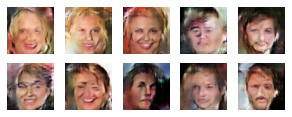

 30%|███       | 60/200 [2:29:47<4:57:31, 127.51s/it]

Time for epoch 60 is 124.41154623031616 sec

--> Currently on Epoch 61


 30%|███       | 61/200 [2:31:51<4:52:43, 126.36s/it]

Time for epoch 61 is 123.65682554244995 sec

--> Currently on Epoch 62


 31%|███       | 62/200 [2:33:55<4:48:52, 125.60s/it]

Time for epoch 62 is 123.82103943824768 sec

--> Currently on Epoch 63


 32%|███▏      | 63/200 [2:35:59<4:45:31, 125.05s/it]

Time for epoch 63 is 123.77237796783447 sec

--> Currently on Epoch 64


 32%|███▏      | 64/200 [2:38:02<4:42:28, 124.62s/it]

Time for epoch 64 is 123.61380982398987 sec

--> Currently on Epoch 65
1/1 [==============================] - 0s 47ms/step


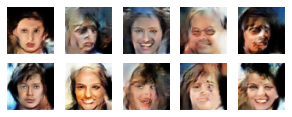

 32%|███▎      | 65/200 [2:40:07<4:40:05, 124.49s/it]

Time for epoch 65 is 124.1625907421112 sec

--> Currently on Epoch 66


 33%|███▎      | 66/200 [2:42:10<4:37:17, 124.16s/it]

Time for epoch 66 is 123.38780093193054 sec

--> Currently on Epoch 67


 34%|███▎      | 67/200 [2:44:14<4:34:53, 124.01s/it]

Time for epoch 67 is 123.65898060798645 sec

--> Currently on Epoch 68


 34%|███▍      | 68/200 [2:46:17<4:32:31, 123.88s/it]

Time for epoch 68 is 123.55923390388489 sec

--> Currently on Epoch 69


 34%|███▍      | 69/200 [2:48:21<4:30:15, 123.78s/it]

Time for epoch 69 is 123.55658555030823 sec

--> Currently on Epoch 70
1/1 [==============================] - 0s 48ms/step


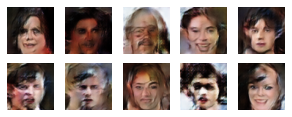

 35%|███▌      | 70/200 [2:50:25<4:28:41, 124.01s/it]

Time for epoch 70 is 124.5541639328003 sec

--> Currently on Epoch 71


 36%|███▌      | 71/200 [2:52:29<4:26:16, 123.85s/it]

Time for epoch 71 is 123.46042013168335 sec

--> Currently on Epoch 72


 36%|███▌      | 72/200 [2:54:51<4:35:46, 129.27s/it]

Time for epoch 72 is 141.91323828697205 sec

--> Currently on Epoch 73


 36%|███▋      | 73/200 [2:56:53<4:29:26, 127.29s/it]

Time for epoch 73 is 122.67163562774658 sec

--> Currently on Epoch 74


 37%|███▋      | 74/200 [2:58:57<4:25:12, 126.29s/it]

Time for epoch 74 is 123.95395684242249 sec

--> Currently on Epoch 75
1/1 [==============================] - 0s 54ms/step


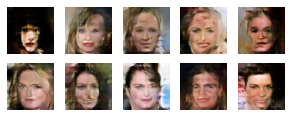

 38%|███▊      | 75/200 [3:01:02<4:21:59, 125.75s/it]

Time for epoch 75 is 124.48814296722412 sec

--> Currently on Epoch 76


 38%|███▊      | 76/200 [3:03:05<4:18:32, 125.10s/it]

Time for epoch 76 is 123.57738161087036 sec

--> Currently on Epoch 77


 38%|███▊      | 77/200 [3:05:09<4:15:32, 124.66s/it]

Time for epoch 77 is 123.61700057983398 sec

--> Currently on Epoch 78


 39%|███▉      | 78/200 [3:07:13<4:12:47, 124.33s/it]

Time for epoch 78 is 123.5481390953064 sec

--> Currently on Epoch 79


 40%|███▉      | 79/200 [3:09:16<4:10:22, 124.16s/it]

Time for epoch 79 is 123.75604033470154 sec

--> Currently on Epoch 80
1/1 [==============================] - 0s 45ms/step


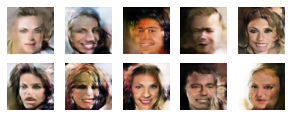

 40%|████      | 80/200 [3:11:21<4:08:28, 124.24s/it]

Time for epoch 80 is 124.42321038246155 sec

--> Currently on Epoch 81


 40%|████      | 81/200 [3:13:24<4:05:56, 124.00s/it]

Time for epoch 81 is 123.44914698600769 sec

--> Currently on Epoch 82


 41%|████      | 82/200 [3:15:28<4:03:39, 123.90s/it]

Time for epoch 82 is 123.64020204544067 sec

--> Currently on Epoch 83


 42%|████▏     | 83/200 [3:17:32<4:01:31, 123.86s/it]

Time for epoch 83 is 123.75950026512146 sec

--> Currently on Epoch 84


 42%|████▏     | 84/200 [3:19:35<3:59:23, 123.82s/it]

Time for epoch 84 is 123.74267292022705 sec

--> Currently on Epoch 85
1/1 [==============================] - 0s 46ms/step


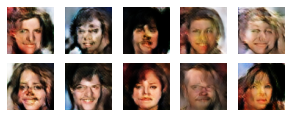

 42%|████▎     | 85/200 [3:21:40<3:57:35, 123.96s/it]

Time for epoch 85 is 124.28132104873657 sec

--> Currently on Epoch 86


 43%|████▎     | 86/200 [3:23:43<3:55:08, 123.76s/it]

Time for epoch 86 is 123.29221725463867 sec

--> Currently on Epoch 87


 44%|████▎     | 87/200 [3:25:47<3:53:04, 123.75s/it]

Time for epoch 87 is 123.72751927375793 sec

--> Currently on Epoch 88


 44%|████▍     | 88/200 [3:27:50<3:50:58, 123.73s/it]

Time for epoch 88 is 123.68695044517517 sec

--> Currently on Epoch 89


 44%|████▍     | 89/200 [3:29:54<3:48:58, 123.77s/it]

Time for epoch 89 is 123.85300803184509 sec

--> Currently on Epoch 90
1/1 [==============================] - 0s 44ms/step


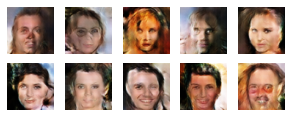

 45%|████▌     | 90/200 [3:31:58<3:46:57, 123.80s/it]

Time for epoch 90 is 123.84681868553162 sec

--> Currently on Epoch 91


 46%|████▌     | 91/200 [3:34:01<3:44:40, 123.67s/it]

Time for epoch 91 is 123.37878346443176 sec

--> Currently on Epoch 92


 46%|████▌     | 92/200 [3:36:05<3:42:40, 123.71s/it]

Time for epoch 92 is 123.77883410453796 sec

--> Currently on Epoch 93


 46%|████▋     | 93/200 [3:38:09<3:40:36, 123.71s/it]

Time for epoch 93 is 123.69843029975891 sec

--> Currently on Epoch 94


 47%|████▋     | 94/200 [3:40:13<3:38:31, 123.70s/it]

Time for epoch 94 is 123.67337083816528 sec

--> Currently on Epoch 95
1/1 [==============================] - 0s 58ms/step


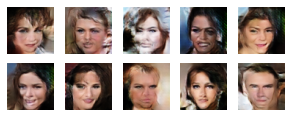

 48%|████▊     | 95/200 [3:42:18<3:37:22, 124.21s/it]

Time for epoch 95 is 125.4110975265503 sec

--> Currently on Epoch 96


 48%|████▊     | 96/200 [3:44:41<3:45:08, 129.89s/it]

Time for epoch 96 is 143.14000988006592 sec

--> Currently on Epoch 97


 48%|████▊     | 97/200 [3:47:05<3:49:55, 133.94s/it]

Time for epoch 97 is 143.38542890548706 sec

--> Currently on Epoch 98


 49%|████▉     | 98/200 [3:49:28<3:52:30, 136.77s/it]

Time for epoch 98 is 143.3578019142151 sec

--> Currently on Epoch 99


 50%|████▉     | 99/200 [3:51:51<3:53:31, 138.73s/it]

Time for epoch 99 is 143.29771661758423 sec

--> Currently on Epoch 100
1/1 [==============================] - 0s 45ms/step


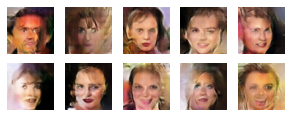

 50%|█████     | 100/200 [3:54:16<3:54:06, 140.47s/it]

Time for epoch 100 is 144.51384234428406 sec

--> Currently on Epoch 101


 50%|█████     | 101/200 [3:56:39<3:53:02, 141.23s/it]

Time for epoch 101 is 143.02512335777283 sec

--> Currently on Epoch 102


 51%|█████     | 102/200 [3:59:02<3:51:40, 141.84s/it]

Time for epoch 102 is 143.2630021572113 sec

--> Currently on Epoch 103


 52%|█████▏    | 103/200 [4:01:25<3:50:03, 142.30s/it]

Time for epoch 103 is 143.3640992641449 sec

--> Currently on Epoch 104


 52%|█████▏    | 104/200 [4:03:49<3:48:07, 142.58s/it]

Time for epoch 104 is 143.22956776618958 sec

--> Currently on Epoch 105
1/1 [==============================] - 0s 44ms/step


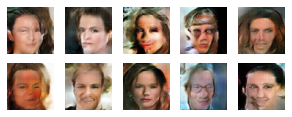

 52%|█████▎    | 105/200 [4:06:13<3:46:22, 142.98s/it]

Time for epoch 105 is 143.89622044563293 sec

--> Currently on Epoch 106


 53%|█████▎    | 106/200 [4:08:36<3:44:02, 143.01s/it]

Time for epoch 106 is 143.0782651901245 sec

--> Currently on Epoch 107


 54%|█████▎    | 107/200 [4:10:59<3:41:45, 143.06s/it]

Time for epoch 107 is 143.18985605239868 sec

--> Currently on Epoch 108


 54%|█████▍    | 108/200 [4:13:22<3:39:21, 143.06s/it]

Time for epoch 108 is 143.04414558410645 sec

--> Currently on Epoch 109


 55%|█████▍    | 109/200 [4:15:45<3:37:04, 143.13s/it]

Time for epoch 109 is 143.28474068641663 sec

--> Currently on Epoch 110
1/1 [==============================] - 0s 34ms/step


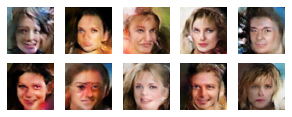

 55%|█████▌    | 110/200 [4:19:07<4:01:17, 160.86s/it]

Time for epoch 110 is 202.2414300441742 sec

--> Currently on Epoch 111


 56%|█████▌    | 111/200 [4:21:30<3:50:32, 155.42s/it]

Time for epoch 111 is 142.71694612503052 sec

--> Currently on Epoch 112


 56%|█████▌    | 112/200 [4:23:54<3:42:51, 151.95s/it]

Time for epoch 112 is 143.8543655872345 sec

--> Currently on Epoch 113


 56%|█████▋    | 113/200 [4:26:18<3:36:41, 149.44s/it]

Time for epoch 113 is 143.58005833625793 sec

--> Currently on Epoch 114


 57%|█████▋    | 114/200 [4:28:41<3:31:42, 147.71s/it]

Time for epoch 114 is 143.65672516822815 sec

--> Currently on Epoch 115
1/1 [==============================] - 0s 45ms/step


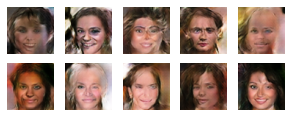

 57%|█████▊    | 115/200 [4:31:05<3:27:44, 146.64s/it]

Time for epoch 115 is 144.1325535774231 sec

--> Currently on Epoch 116


 58%|█████▊    | 116/200 [4:33:29<3:23:54, 145.65s/it]

Time for epoch 116 is 143.3334617614746 sec

--> Currently on Epoch 117


 58%|█████▊    | 117/200 [4:35:52<3:20:36, 145.02s/it]

Time for epoch 117 is 143.53988528251648 sec

--> Currently on Epoch 118


 59%|█████▉    | 118/200 [4:38:16<3:17:30, 144.51s/it]

Time for epoch 118 is 143.33464670181274 sec

--> Currently on Epoch 119


 60%|█████▉    | 119/200 [4:40:39<3:14:38, 144.18s/it]

Time for epoch 119 is 143.39623403549194 sec

--> Currently on Epoch 120
1/1 [==============================] - 0s 34ms/step


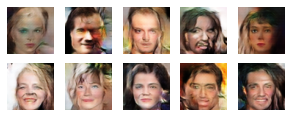

 60%|██████    | 120/200 [4:43:03<3:12:09, 144.11s/it]

Time for epoch 120 is 143.95772695541382 sec

--> Currently on Epoch 121


 60%|██████    | 121/200 [4:45:26<3:09:17, 143.77s/it]

Time for epoch 121 is 142.95744681358337 sec

--> Currently on Epoch 122


 61%|██████    | 122/200 [4:47:49<3:06:48, 143.70s/it]

Time for epoch 122 is 143.53956198692322 sec

--> Currently on Epoch 123


 62%|██████▏   | 123/200 [4:50:13<3:04:18, 143.61s/it]

Time for epoch 123 is 143.40122175216675 sec

--> Currently on Epoch 124


 62%|██████▏   | 124/200 [4:52:36<3:01:50, 143.57s/it]

Time for epoch 124 is 143.451922416687 sec

--> Currently on Epoch 125
1/1 [==============================] - 0s 45ms/step


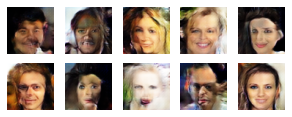

 62%|██████▎   | 125/200 [4:55:00<2:59:40, 143.74s/it]

Time for epoch 125 is 144.127760887146 sec

--> Currently on Epoch 126


 63%|██████▎   | 126/200 [4:57:23<2:56:58, 143.49s/it]

Time for epoch 126 is 142.9254195690155 sec

--> Currently on Epoch 127


 64%|██████▎   | 127/200 [4:59:47<2:54:30, 143.44s/it]

Time for epoch 127 is 143.2961127758026 sec

--> Currently on Epoch 128


 64%|██████▍   | 128/200 [5:02:10<2:52:02, 143.37s/it]

Time for epoch 128 is 143.20794701576233 sec

--> Currently on Epoch 129


 64%|██████▍   | 129/200 [5:04:33<2:49:41, 143.40s/it]

Time for epoch 129 is 143.48118591308594 sec

--> Currently on Epoch 130
1/1 [==============================] - 0s 34ms/step


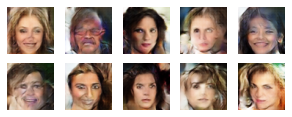

 65%|██████▌   | 130/200 [5:06:58<2:47:37, 143.68s/it]

Time for epoch 130 is 144.30255842208862 sec

--> Currently on Epoch 131


 66%|██████▌   | 131/200 [5:09:21<2:44:58, 143.46s/it]

Time for epoch 131 is 142.945387840271 sec

--> Currently on Epoch 132


 66%|██████▌   | 132/200 [5:11:44<2:42:32, 143.41s/it]

Time for epoch 132 is 143.3063497543335 sec

--> Currently on Epoch 133


 66%|██████▋   | 133/200 [5:14:07<2:40:05, 143.37s/it]

Time for epoch 133 is 143.2548475265503 sec

--> Currently on Epoch 134


 67%|██████▋   | 134/200 [5:17:29<2:57:01, 160.93s/it]

Time for epoch 134 is 201.91432213783264 sec

--> Currently on Epoch 135
1/1 [==============================] - 0s 44ms/step


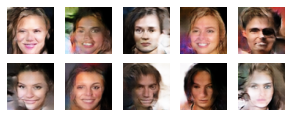

 68%|██████▊   | 135/200 [5:19:53<2:48:38, 155.66s/it]

Time for epoch 135 is 143.36551809310913 sec

--> Currently on Epoch 136


 68%|██████▊   | 136/200 [5:22:16<2:42:08, 152.00s/it]

Time for epoch 136 is 143.45194149017334 sec

--> Currently on Epoch 137


 68%|██████▊   | 137/200 [5:24:40<2:36:57, 149.48s/it]

Time for epoch 137 is 143.59982538223267 sec

--> Currently on Epoch 138


 69%|██████▉   | 138/200 [5:27:03<2:32:37, 147.70s/it]

Time for epoch 138 is 143.53509545326233 sec

--> Currently on Epoch 139


 70%|██████▉   | 139/200 [5:29:27<2:28:56, 146.49s/it]

Time for epoch 139 is 143.6744360923767 sec

--> Currently on Epoch 140
1/1 [==============================] - 0s 43ms/step


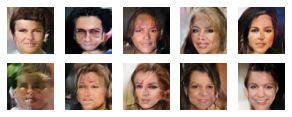

 70%|███████   | 140/200 [5:31:51<2:25:49, 145.82s/it]

Time for epoch 140 is 144.23490619659424 sec

--> Currently on Epoch 141


 70%|███████   | 141/200 [5:34:14<2:22:37, 145.04s/it]

Time for epoch 141 is 143.2061197757721 sec

--> Currently on Epoch 142


 71%|███████   | 142/200 [5:36:38<2:19:47, 144.62s/it]

Time for epoch 142 is 143.63119792938232 sec

--> Currently on Epoch 143


 72%|███████▏  | 143/200 [5:39:01<2:17:02, 144.26s/it]

Time for epoch 143 is 143.42826771736145 sec

--> Currently on Epoch 144


 72%|███████▏  | 144/200 [5:41:25<2:14:21, 143.96s/it]

Time for epoch 144 is 143.25968551635742 sec

--> Currently on Epoch 145
1/1 [==============================] - 0s 39ms/step


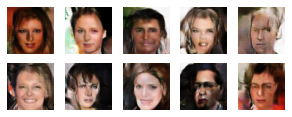

 72%|███████▎  | 145/200 [5:43:49<2:12:01, 144.03s/it]

Time for epoch 145 is 144.18974900245667 sec

--> Currently on Epoch 146


 73%|███████▎  | 146/200 [5:46:12<2:09:22, 143.74s/it]

Time for epoch 146 is 143.06552147865295 sec

--> Currently on Epoch 147


 74%|███████▎  | 147/200 [5:48:35<2:06:50, 143.60s/it]

Time for epoch 147 is 143.25634908676147 sec

--> Currently on Epoch 148


 74%|███████▍  | 148/200 [5:50:59<2:04:25, 143.56s/it]

Time for epoch 148 is 143.46777844429016 sec

--> Currently on Epoch 149


 74%|███████▍  | 149/200 [5:53:22<2:01:59, 143.53s/it]

Time for epoch 149 is 143.44391250610352 sec

--> Currently on Epoch 150
1/1 [==============================] - 0s 48ms/step


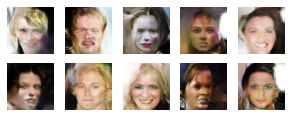

 75%|███████▌  | 150/200 [5:55:46<1:59:45, 143.71s/it]

Time for epoch 150 is 144.14140343666077 sec

--> Currently on Epoch 151


 76%|███████▌  | 151/200 [5:58:09<1:57:12, 143.51s/it]

Time for epoch 151 is 143.04702520370483 sec

--> Currently on Epoch 152


 76%|███████▌  | 152/200 [6:00:32<1:54:45, 143.44s/it]

Time for epoch 152 is 143.27432513237 sec

--> Currently on Epoch 153


 76%|███████▋  | 153/200 [6:02:56<1:52:18, 143.38s/it]

Time for epoch 153 is 143.2121720314026 sec

--> Currently on Epoch 154


 77%|███████▋  | 154/200 [6:05:19<1:49:53, 143.33s/it]

Time for epoch 154 is 143.23085379600525 sec

--> Currently on Epoch 155
1/1 [==============================] - 0s 47ms/step


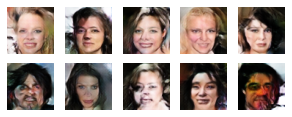

 78%|███████▊  | 155/200 [6:07:43<1:47:41, 143.59s/it]

Time for epoch 155 is 144.18786311149597 sec

--> Currently on Epoch 156


 78%|███████▊  | 156/200 [6:10:06<1:45:12, 143.47s/it]

Time for epoch 156 is 143.1769187450409 sec

--> Currently on Epoch 157


 78%|███████▊  | 157/200 [6:12:30<1:42:45, 143.39s/it]

Time for epoch 157 is 143.20767092704773 sec

--> Currently on Epoch 158


 79%|███████▉  | 158/200 [6:14:53<1:40:20, 143.34s/it]

Time for epoch 158 is 143.21709179878235 sec

--> Currently on Epoch 159


 80%|███████▉  | 159/200 [6:17:16<1:37:56, 143.33s/it]

Time for epoch 159 is 143.29950141906738 sec

--> Currently on Epoch 160
1/1 [==============================] - 0s 36ms/step


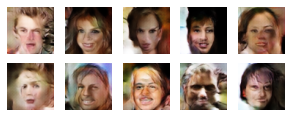

 80%|████████  | 160/200 [6:19:40<1:35:44, 143.60s/it]

Time for epoch 160 is 144.2360873222351 sec

--> Currently on Epoch 161


 80%|████████  | 161/200 [6:22:03<1:33:13, 143.43s/it]

Time for epoch 161 is 143.0149703025818 sec

--> Currently on Epoch 162


 81%|████████  | 162/200 [6:24:27<1:30:49, 143.41s/it]

Time for epoch 162 is 143.36841988563538 sec

--> Currently on Epoch 163


 82%|████████▏ | 163/200 [6:26:50<1:28:25, 143.39s/it]

Time for epoch 163 is 143.34727025032043 sec

--> Currently on Epoch 164


 82%|████████▏ | 164/200 [6:29:13<1:26:02, 143.39s/it]

Time for epoch 164 is 143.3765742778778 sec

--> Currently on Epoch 165
1/1 [==============================] - 0s 39ms/step


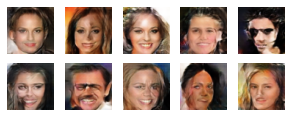

 82%|████████▎ | 165/200 [6:31:37<1:23:44, 143.57s/it]

Time for epoch 165 is 143.97851657867432 sec

--> Currently on Epoch 166


 83%|████████▎ | 166/200 [6:34:00<1:21:14, 143.37s/it]

Time for epoch 166 is 142.91635251045227 sec

--> Currently on Epoch 167


 84%|████████▎ | 167/200 [6:36:24<1:18:50, 143.36s/it]

Time for epoch 167 is 143.31059789657593 sec

--> Currently on Epoch 168


 84%|████████▍ | 168/200 [6:38:47<1:16:28, 143.38s/it]

Time for epoch 168 is 143.44003438949585 sec

--> Currently on Epoch 169


 84%|████████▍ | 169/200 [6:41:10<1:14:05, 143.39s/it]

Time for epoch 169 is 143.39375686645508 sec

--> Currently on Epoch 170
1/1 [==============================] - 0s 47ms/step


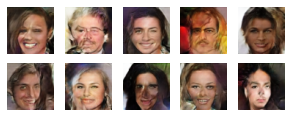

 85%|████████▌ | 170/200 [6:43:34<1:11:46, 143.55s/it]

Time for epoch 170 is 143.90890383720398 sec

--> Currently on Epoch 171


 86%|████████▌ | 171/200 [6:45:57<1:09:18, 143.40s/it]

Time for epoch 171 is 143.05694341659546 sec

--> Currently on Epoch 172


 86%|████████▌ | 172/200 [6:48:21<1:06:54, 143.39s/it]

Time for epoch 172 is 143.3480896949768 sec

--> Currently on Epoch 173


 86%|████████▋ | 173/200 [6:50:44<1:04:31, 143.37s/it]

Time for epoch 173 is 143.32928657531738 sec

--> Currently on Epoch 174


 87%|████████▋ | 174/200 [6:53:07<1:02:07, 143.35s/it]

Time for epoch 174 is 143.29101490974426 sec

--> Currently on Epoch 175
1/1 [==============================] - 0s 44ms/step


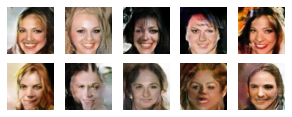

 88%|████████▊ | 175/200 [6:55:32<59:49, 143.59s/it]  

Time for epoch 175 is 144.15636563301086 sec

--> Currently on Epoch 176


 88%|████████▊ | 176/200 [6:57:55<57:24, 143.51s/it]

Time for epoch 176 is 143.30187487602234 sec

--> Currently on Epoch 177


 88%|████████▊ | 177/200 [7:00:18<54:59, 143.46s/it]

Time for epoch 177 is 143.3491449356079 sec

--> Currently on Epoch 178


 89%|████████▉ | 178/200 [7:02:41<52:34, 143.37s/it]

Time for epoch 178 is 143.14723658561707 sec

--> Currently on Epoch 179


 90%|████████▉ | 179/200 [7:05:05<50:10, 143.37s/it]

Time for epoch 179 is 143.3538200855255 sec

--> Currently on Epoch 180
1/1 [==============================] - 0s 47ms/step


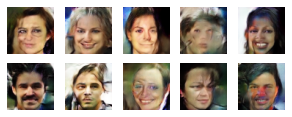

 90%|█████████ | 180/200 [7:07:29<47:50, 143.51s/it]

Time for epoch 180 is 143.83701491355896 sec

--> Currently on Epoch 181


 90%|█████████ | 181/200 [7:09:51<45:22, 143.31s/it]

Time for epoch 181 is 142.85419392585754 sec

--> Currently on Epoch 182


 91%|█████████ | 182/200 [7:12:15<42:59, 143.30s/it]

Time for epoch 182 is 143.2715985774994 sec

--> Currently on Epoch 183


 92%|█████████▏| 183/200 [7:14:38<40:36, 143.33s/it]

Time for epoch 183 is 143.39285850524902 sec

--> Currently on Epoch 184


 92%|█████████▏| 184/200 [7:17:01<38:13, 143.33s/it]

Time for epoch 184 is 143.32587790489197 sec

--> Currently on Epoch 185
1/1 [==============================] - 0s 31ms/step


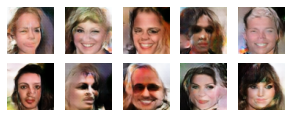

 92%|█████████▎| 185/200 [7:19:25<35:52, 143.49s/it]

Time for epoch 185 is 143.86833834648132 sec

--> Currently on Epoch 186


 93%|█████████▎| 186/200 [7:21:48<33:26, 143.32s/it]

Time for epoch 186 is 142.91102743148804 sec

--> Currently on Epoch 187


 94%|█████████▎| 187/200 [7:24:11<31:02, 143.29s/it]

Time for epoch 187 is 143.20493006706238 sec

--> Currently on Epoch 188


 94%|█████████▍| 188/200 [7:26:35<28:39, 143.30s/it]

Time for epoch 188 is 143.3124063014984 sec

--> Currently on Epoch 189


 94%|█████████▍| 189/200 [7:28:58<26:16, 143.35s/it]

Time for epoch 189 is 143.46006751060486 sec

--> Currently on Epoch 190
1/1 [==============================] - 0s 44ms/step


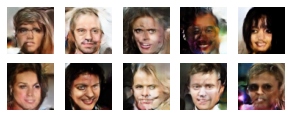

 95%|█████████▌| 190/200 [7:31:23<23:56, 143.64s/it]

Time for epoch 190 is 144.33270025253296 sec

--> Currently on Epoch 191


 96%|█████████▌| 191/200 [7:33:46<21:31, 143.49s/it]

Time for epoch 191 is 143.1241364479065 sec

--> Currently on Epoch 192


 96%|█████████▌| 192/200 [7:36:09<19:07, 143.49s/it]

Time for epoch 192 is 143.47297644615173 sec

--> Currently on Epoch 193


 96%|█████████▋| 193/200 [7:38:33<16:44, 143.46s/it]

Time for epoch 193 is 143.401686668396 sec

--> Currently on Epoch 194


 97%|█████████▋| 194/200 [7:40:56<14:20, 143.41s/it]

Time for epoch 194 is 143.27587699890137 sec

--> Currently on Epoch 195
1/1 [==============================] - 0s 34ms/step


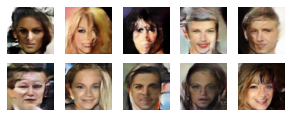

 98%|█████████▊| 195/200 [7:43:20<11:58, 143.63s/it]

Time for epoch 195 is 144.12762141227722 sec

--> Currently on Epoch 196


 98%|█████████▊| 196/200 [7:45:43<09:33, 143.43s/it]

Time for epoch 196 is 142.98188042640686 sec

--> Currently on Epoch 197


 98%|█████████▊| 197/200 [7:48:06<07:10, 143.39s/it]

Time for epoch 197 is 143.28480982780457 sec

--> Currently on Epoch 198


 99%|█████████▉| 198/200 [7:50:30<04:46, 143.38s/it]

Time for epoch 198 is 143.33571672439575 sec

--> Currently on Epoch 199


100%|█████████▉| 199/200 [7:52:53<02:23, 143.44s/it]

Time for epoch 199 is 143.59614443778992 sec

--> Currently on Epoch 200
1/1 [==============================] - 0s 48ms/step


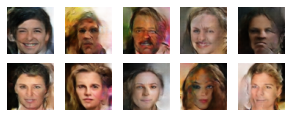

100%|██████████| 200/200 [7:55:17<00:00, 142.59s/it]

Time for epoch 200 is 143.75172996520996 sec


In [ ]:
train(train_dataset, 200)

### 2.4. Visualizing the Results

In this step we will infer the resultant generated images from the training process. Making the necessary alterations to vizualize the images 
clearly.

In [ ]:
noise=np.random.uniform(-1,1,size=[500,NOISE_SHAPE])
im=generator.predict(noise)

16/16 [==============================] - 0s 17ms/step


4/4 [==============================] - 0s 14ms/step


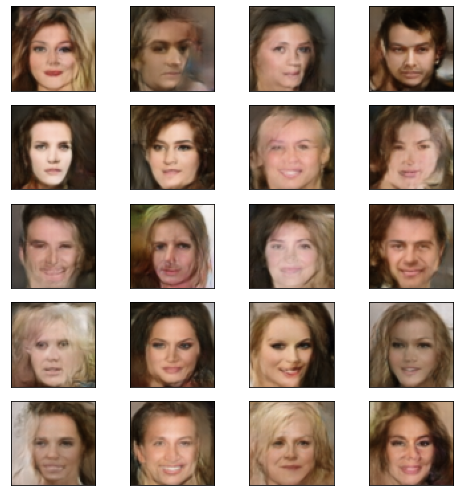

4/4 [==============================] - 0s 14ms/step


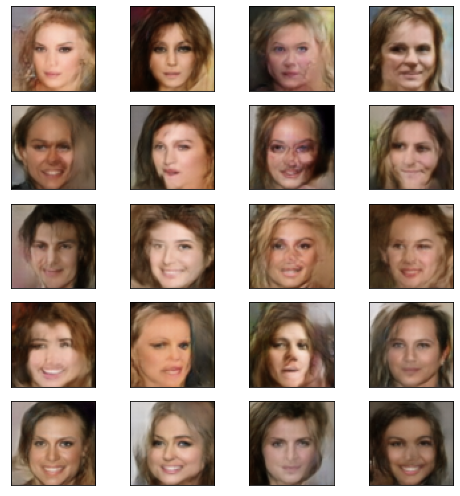

4/4 [==============================] - 0s 13ms/step


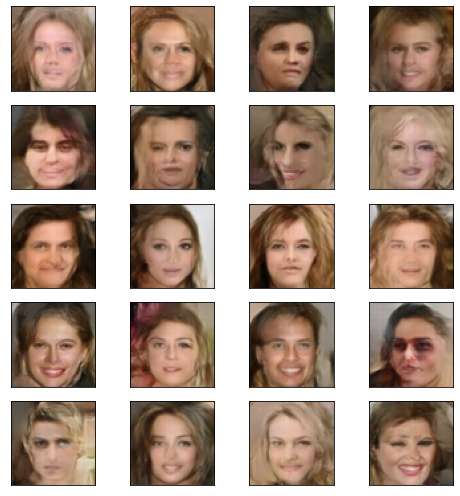

4/4 [==============================] - 0s 13ms/step


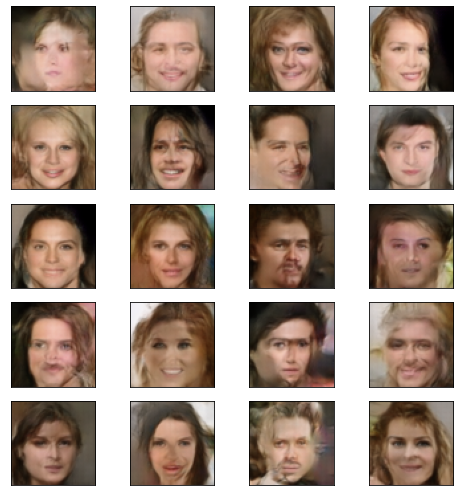

4/4 [==============================] - 0s 13ms/step


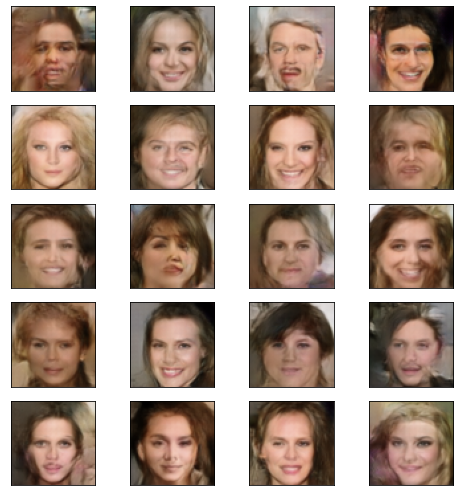

4/4 [==============================] - 0s 14ms/step


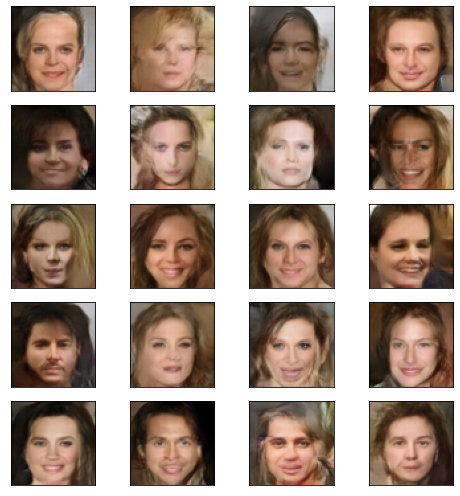

In [ ]:
for i in range(6):
 plt.figure(figsize=(7,7))   
 for k in range(20):
            noise=np.random.uniform(-1,1,size=[100,NOISE_SHAPE])
            im=generator.predict(noise) 
            plt.subplot(5, 4, k+1)
            plt.imshow(((im[k].reshape(64,64,3) + 127.5) * 127.5).astype(np.uint8))
            plt.xticks([])
            plt.yticks([])
 
 plt.tight_layout()
 plt.show()


From 200 epochs we obtain some reasonably good images. By training the model with more epochs, it is expected that the images will improve their reality exponentially. However, due to the processing time and the required performance levels we only run the model for 200 epochs.